# Task 4: Optimize Portfolio Based on Forecast

This notebook implements Modern Portfolio Theory (MPT) using Tesla forecasts from Task 3 and historical SPY/BND data.

## Objectives:
1. Load Tesla forecasts and historical SPY/BND returns
2. Calculate expected returns vector (Tesla forecasts + historical averages)
3. Compute covariance matrix for risk assessment
4. Generate and plot the Efficient Frontier
5. Identify optimal portfolios (Max Sharpe Ratio, Min Volatility)
6. Provide final portfolio allocation recommendations
7. Analyze risk-return trade-offs and portfolio characteristics


In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os
from pathlib import Path

# Portfolio optimization libraries
from scipy.optimize import minimize
from scipy import stats
import yfinance as yf

# Visualization
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("Portfolio optimization tools ready!")


Libraries imported successfully!
Portfolio optimization tools ready!


In [17]:
# Setup paths and load data
print(f"Current working directory: {os.getcwd()}")

# Handle both running from project root or notebooks directory
if 'notebooks' in os.getcwd() and os.path.exists('../data/processed'):
    data_path = '../data/processed/'
else:
    data_path = 'data/processed/'

print(f"Using data path: {data_path}")

# Load Tesla forecasts from Task 3
try:
    tesla_forecasts = pd.read_csv(f'{data_path}task3_future_forecasts.csv', index_col=0, parse_dates=True)
    forecast_summary = pd.read_csv(f'{data_path}task3_forecast_summary.csv')
    
    # Load historical data for all assets
    tesla_data = pd.read_csv(f'{data_path}tsla_processed.csv', index_col=0, parse_dates=True)
    tesla_returns = pd.read_csv(f'{data_path}tsla_returns.csv', index_col=0, parse_dates=True)
    spy_data = pd.read_csv(f'{data_path}spy_processed.csv', index_col=0, parse_dates=True)
    spy_returns = pd.read_csv(f'{data_path}spy_returns.csv', index_col=0, parse_dates=True)
    bnd_data = pd.read_csv(f'{data_path}bnd_processed.csv', index_col=0, parse_dates=True)
    bnd_returns = pd.read_csv(f'{data_path}bnd_returns.csv', index_col=0, parse_dates=True)
    
    print("✅ All data loaded successfully!")
    print(f"• Tesla forecasts: {tesla_forecasts.shape}")
    print(f"• Historical data loaded for TSLA, SPY, BND")
    
    # Extract key forecast metrics
    target_price = forecast_summary['target_price_12m'].iloc[0]
    current_price = forecast_summary['current_price'].iloc[0]
    tesla_expected_return = forecast_summary['total_return_pct'].iloc[0] / 100  # Convert to decimal
    
    print(f"\n📊 Tesla Forecast Summary:")
    print(f"• Current Price: ${current_price:.2f}")
    print(f"• 12-Month Target: ${target_price:.2f}")
    print(f"• Expected Return: {tesla_expected_return*100:.2f}%")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure Tasks 1-3 have been completed.")


Current working directory: /Users/mikiyasegaye/MK_Lab/10 Academy/gmf-time-series-forecasting/notebooks
Using data path: ../data/processed/
✅ All data loaded successfully!
• Tesla forecasts: (252, 4)
• Historical data loaded for TSLA, SPY, BND

📊 Tesla Forecast Summary:
• Current Price: $222.62
• 12-Month Target: $261.16
• Expected Return: 17.31%


In [18]:
# Calculate Expected Returns Vector
print("📊 Calculating expected returns for portfolio optimization...")

# Tesla: Use forecast-based expected return
tesla_exp_return = tesla_expected_return
print(f"TSLA expected return (from forecast): {tesla_exp_return*100:.2f}%")

# SPY: Use historical average annual return
spy_daily_returns = spy_returns.iloc[:, 0].dropna()  # First column
spy_historical_return = spy_daily_returns.mean() * 252  # Annualized
print(f"SPY expected return (historical): {spy_historical_return*100:.2f}%")

# BND: Use historical average annual return
bnd_daily_returns = bnd_returns.iloc[:, 0].dropna()  # First column
bnd_historical_return = bnd_daily_returns.mean() * 252  # Annualized
print(f"BND expected return (historical): {bnd_historical_return*100:.2f}%")

# Create expected returns vector
assets = ['TSLA', 'SPY', 'BND']
expected_returns = np.array([tesla_exp_return, spy_historical_return, bnd_historical_return])

print(f"\n🎯 Expected Returns Vector:")
for i, asset in enumerate(assets):
    print(f"• {asset}: {expected_returns[i]*100:.2f}%")

# Display summary statistics
returns_df = pd.DataFrame({
    'Asset': assets,
    'Expected_Return_Annual': expected_returns * 100,
    'Data_Source': ['Tesla Forecast', 'Historical Average', 'Historical Average']
})

print(f"\n📋 Expected Returns Summary:")
display(returns_df)


📊 Calculating expected returns for portfolio optimization...
TSLA expected return (from forecast): 17.31%
SPY expected return (historical): 14.48%
BND expected return (historical): 1.96%

🎯 Expected Returns Vector:
• TSLA: 17.31%
• SPY: 14.48%
• BND: 1.96%

📋 Expected Returns Summary:


,Asset,Expected_Return_Annual,Data_Source
0,TSLA,17.313688,Tesla Forecast
1,SPY,14.484442,Historical Average
2,BND,1.959936,Historical Average


📈 Calculating covariance matrix for risk assessment...
✅ Aligned returns data:
• Common dates: 2284 observations
• Date range: 2015-07-02 to 2024-07-30
• Assets: ['TSLA', 'SPY', 'BND']

📊 Annual Covariance Matrix:


,TSLA,SPY,BND
TSLA,0.331121,0.048335,0.001920
SPY,0.048335,0.032431,0.001201
BND,0.001920,0.001201,0.003055



🔗 Correlation Matrix:


,TSLA,SPY,BND
TSLA,1.000,0.466,0.060
SPY,0.466,1.000,0.121
BND,0.060,0.121,1.000


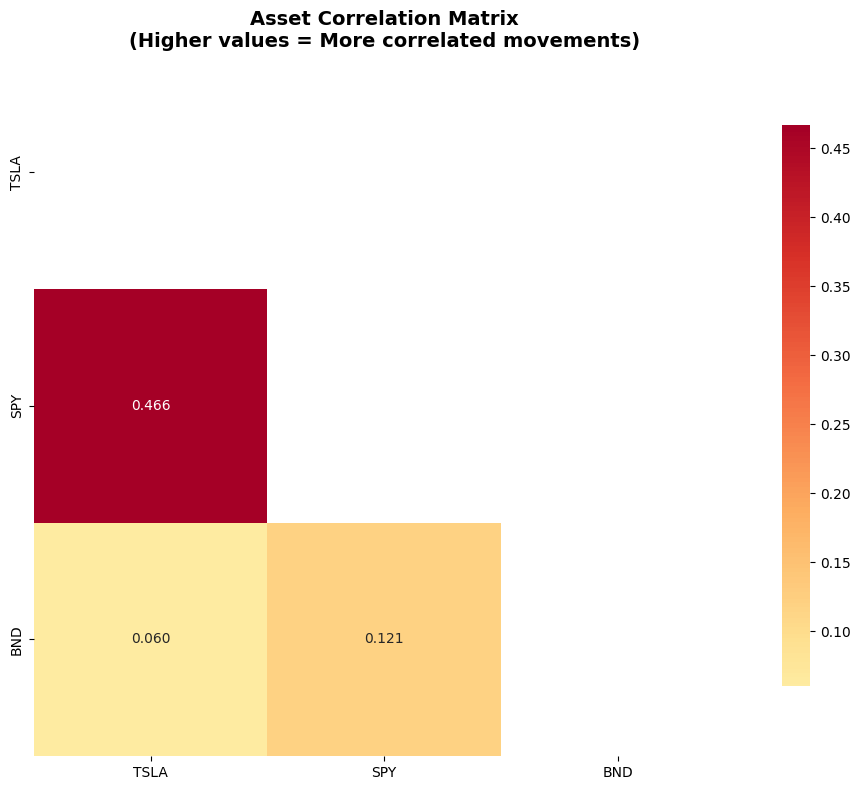


📉 Individual Asset Volatilities (Annualized):
• TSLA: 57.54%
• SPY: 18.01%
• BND: 5.53%


In [19]:
# Calculate Covariance Matrix
print("📈 Calculating covariance matrix for risk assessment...")

# Combine all daily returns for covariance calculation
tesla_daily_returns = tesla_returns.iloc[:, 0].dropna()

# Align all return series to common dates
common_dates = tesla_daily_returns.index.intersection(spy_daily_returns.index).intersection(bnd_daily_returns.index)

# Create aligned returns dataframe
aligned_returns = pd.DataFrame({
    'TSLA': tesla_daily_returns.loc[common_dates],
    'SPY': spy_daily_returns.loc[common_dates], 
    'BND': bnd_daily_returns.loc[common_dates]
})

# Remove any remaining NaN values
aligned_returns = aligned_returns.dropna()

print(f"✅ Aligned returns data:")
print(f"• Common dates: {len(aligned_returns)} observations")
print(f"• Date range: {aligned_returns.index.min().date()} to {aligned_returns.index.max().date()}")
print(f"• Assets: {list(aligned_returns.columns)}")

# Calculate daily covariance matrix and annualize
daily_cov_matrix = aligned_returns.cov()
annual_cov_matrix = daily_cov_matrix * 252  # Annualize

print(f"\n📊 Annual Covariance Matrix:")
display(annual_cov_matrix.round(6))

# Calculate correlation matrix for interpretation
correlation_matrix = aligned_returns.corr()
print(f"\n🔗 Correlation Matrix:")
display(correlation_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Asset Correlation Matrix\n(Higher values = More correlated movements)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate individual asset volatilities (annualized)
annual_volatilities = np.sqrt(np.diag(annual_cov_matrix))
print(f"\n📉 Individual Asset Volatilities (Annualized):")
for i, asset in enumerate(assets):
    print(f"• {asset}: {annual_volatilities[i]*100:.2f}%")


In [20]:
# Portfolio Optimization Functions
print("⚙️ Setting up portfolio optimization functions...")

def portfolio_performance(weights, expected_returns, cov_matrix):
    """Calculate portfolio return and volatility"""
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def portfolio_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.03):
    """Calculate portfolio Sharpe ratio"""
    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return sharpe_ratio

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.03):
    """Negative Sharpe ratio for minimization"""
    return -portfolio_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate)

def portfolio_volatility(weights, expected_returns, cov_matrix):
    """Calculate portfolio volatility for minimization"""
    _, vol = portfolio_performance(weights, expected_returns, cov_matrix)
    return vol

# Set optimization constraints and bounds
num_assets = len(assets)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling, max 100% in any asset

# Risk-free rate assumption (3% annual)
risk_free_rate = 0.03

print("✅ Portfolio optimization functions ready!")
print(f"• Number of assets: {num_assets}")
print(f"• Risk-free rate: {risk_free_rate*100:.1f}%")
print(f"• Constraints: Weights sum to 1, no short selling")

# Test with equal weights
equal_weights = np.array([1/num_assets] * num_assets)
test_return, test_vol = portfolio_performance(equal_weights, expected_returns, annual_cov_matrix)
test_sharpe = portfolio_sharpe_ratio(equal_weights, expected_returns, annual_cov_matrix, risk_free_rate)

print(f"\n📊 Equal Weight Portfolio Test:")
print(f"• Weights: {[f'{w*100:.1f}%' for w in equal_weights]}")
print(f"• Expected Return: {test_return*100:.2f}%")
print(f"• Volatility: {test_vol*100:.2f}%")
print(f"• Sharpe Ratio: {test_sharpe:.3f}")


⚙️ Setting up portfolio optimization functions...
✅ Portfolio optimization functions ready!
• Number of assets: 3
• Risk-free rate: 3.0%
• Constraints: Weights sum to 1, no short selling

📊 Equal Weight Portfolio Test:
• Weights: ['33.3%', '33.3%', '33.3%']
• Expected Return: 11.25%
• Volatility: 22.84%
• Sharpe Ratio: 0.361


In [21]:
# Find Optimal Portfolios
print("🎯 Finding optimal portfolios...")

# 1. Maximum Sharpe Ratio Portfolio (Tangency Portfolio)
print("\n📈 Optimizing for Maximum Sharpe Ratio...")
initial_guess = equal_weights
result_sharpe = minimize(negative_sharpe_ratio, initial_guess, 
                        args=(expected_returns, annual_cov_matrix, risk_free_rate),
                        method='SLSQP', bounds=bounds, constraints=constraints)

if result_sharpe.success:
    max_sharpe_weights = result_sharpe.x
    max_sharpe_return, max_sharpe_vol = portfolio_performance(max_sharpe_weights, expected_returns, annual_cov_matrix)
    max_sharpe_ratio = portfolio_sharpe_ratio(max_sharpe_weights, expected_returns, annual_cov_matrix, risk_free_rate)
    
    print("✅ Maximum Sharpe Ratio Portfolio found!")
    print(f"• TSLA: {max_sharpe_weights[0]*100:.1f}%")
    print(f"• SPY: {max_sharpe_weights[1]*100:.1f}%") 
    print(f"• BND: {max_sharpe_weights[2]*100:.1f}%")
    print(f"• Expected Return: {max_sharpe_return*100:.2f}%")
    print(f"• Volatility: {max_sharpe_vol*100:.2f}%")
    print(f"• Sharpe Ratio: {max_sharpe_ratio:.3f}")
else:
    print("❌ Maximum Sharpe Ratio optimization failed")

# 2. Minimum Volatility Portfolio  
print("\n📉 Optimizing for Minimum Volatility...")
result_vol = minimize(portfolio_volatility, initial_guess,
                     args=(expected_returns, annual_cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)

if result_vol.success:
    min_vol_weights = result_vol.x
    min_vol_return, min_vol_vol = portfolio_performance(min_vol_weights, expected_returns, annual_cov_matrix)
    min_vol_sharpe = portfolio_sharpe_ratio(min_vol_weights, expected_returns, annual_cov_matrix, risk_free_rate)
    
    print("✅ Minimum Volatility Portfolio found!")
    print(f"• TSLA: {min_vol_weights[0]*100:.1f}%")
    print(f"• SPY: {min_vol_weights[1]*100:.1f}%")
    print(f"• BND: {min_vol_weights[2]*100:.1f}%") 
    print(f"• Expected Return: {min_vol_return*100:.2f}%")
    print(f"• Volatility: {min_vol_vol*100:.2f}%")
    print(f"• Sharpe Ratio: {min_vol_sharpe:.3f}")
else:
    print("❌ Minimum Volatility optimization failed")

# Create optimal portfolios summary
optimal_portfolios = pd.DataFrame({
    'Portfolio': ['Equal Weight', 'Max Sharpe Ratio', 'Min Volatility'],
    'TSLA_Weight': [equal_weights[0]*100, max_sharpe_weights[0]*100 if result_sharpe.success else np.nan, 
                    min_vol_weights[0]*100 if result_vol.success else np.nan],
    'SPY_Weight': [equal_weights[1]*100, max_sharpe_weights[1]*100 if result_sharpe.success else np.nan,
                   min_vol_weights[1]*100 if result_vol.success else np.nan],
    'BND_Weight': [equal_weights[2]*100, max_sharpe_weights[2]*100 if result_sharpe.success else np.nan,
                   min_vol_weights[2]*100 if result_vol.success else np.nan],
    'Expected_Return': [test_return*100, max_sharpe_return*100 if result_sharpe.success else np.nan,
                       min_vol_return*100 if result_vol.success else np.nan],
    'Volatility': [test_vol*100, max_sharpe_vol*100 if result_sharpe.success else np.nan,
                  min_vol_vol*100 if result_vol.success else np.nan],
    'Sharpe_Ratio': [test_sharpe, max_sharpe_ratio if result_sharpe.success else np.nan,
                    min_vol_sharpe if result_vol.success else np.nan]
})

print(f"\n📊 Optimal Portfolios Summary:")
display(optimal_portfolios.round(2))


🎯 Finding optimal portfolios...

📈 Optimizing for Maximum Sharpe Ratio...
✅ Maximum Sharpe Ratio Portfolio found!
• TSLA: 0.0%
• SPY: 100.0%
• BND: 0.0%
• Expected Return: 14.48%
• Volatility: 18.01%
• Sharpe Ratio: 0.638

📉 Optimizing for Minimum Volatility...
✅ Minimum Volatility Portfolio found!
• TSLA: 0.0%
• SPY: 5.6%
• BND: 94.4%
• Expected Return: 2.66%
• Volatility: 5.43%
• Sharpe Ratio: -0.063

📊 Optimal Portfolios Summary:


,Portfolio,TSLA_Weight,SPY_Weight,BND_Weight,Expected_Return,Volatility,Sharpe_Ratio
0,Equal Weight,33.33,33.33,33.33,11.25,22.84,0.36
1,Max Sharpe Ratio,0.00,100.00,0.00,14.48,18.01,0.64
2,Min Volatility,0.00,5.58,94.42,2.66,5.43,-0.06


📊 Generating Efficient Frontier...
✅ Efficient Frontier generated!
• Generated 50 efficient portfolios
• Return range: 2.66% to 17.31%
• Volatility range: 5.43% to 57.54%


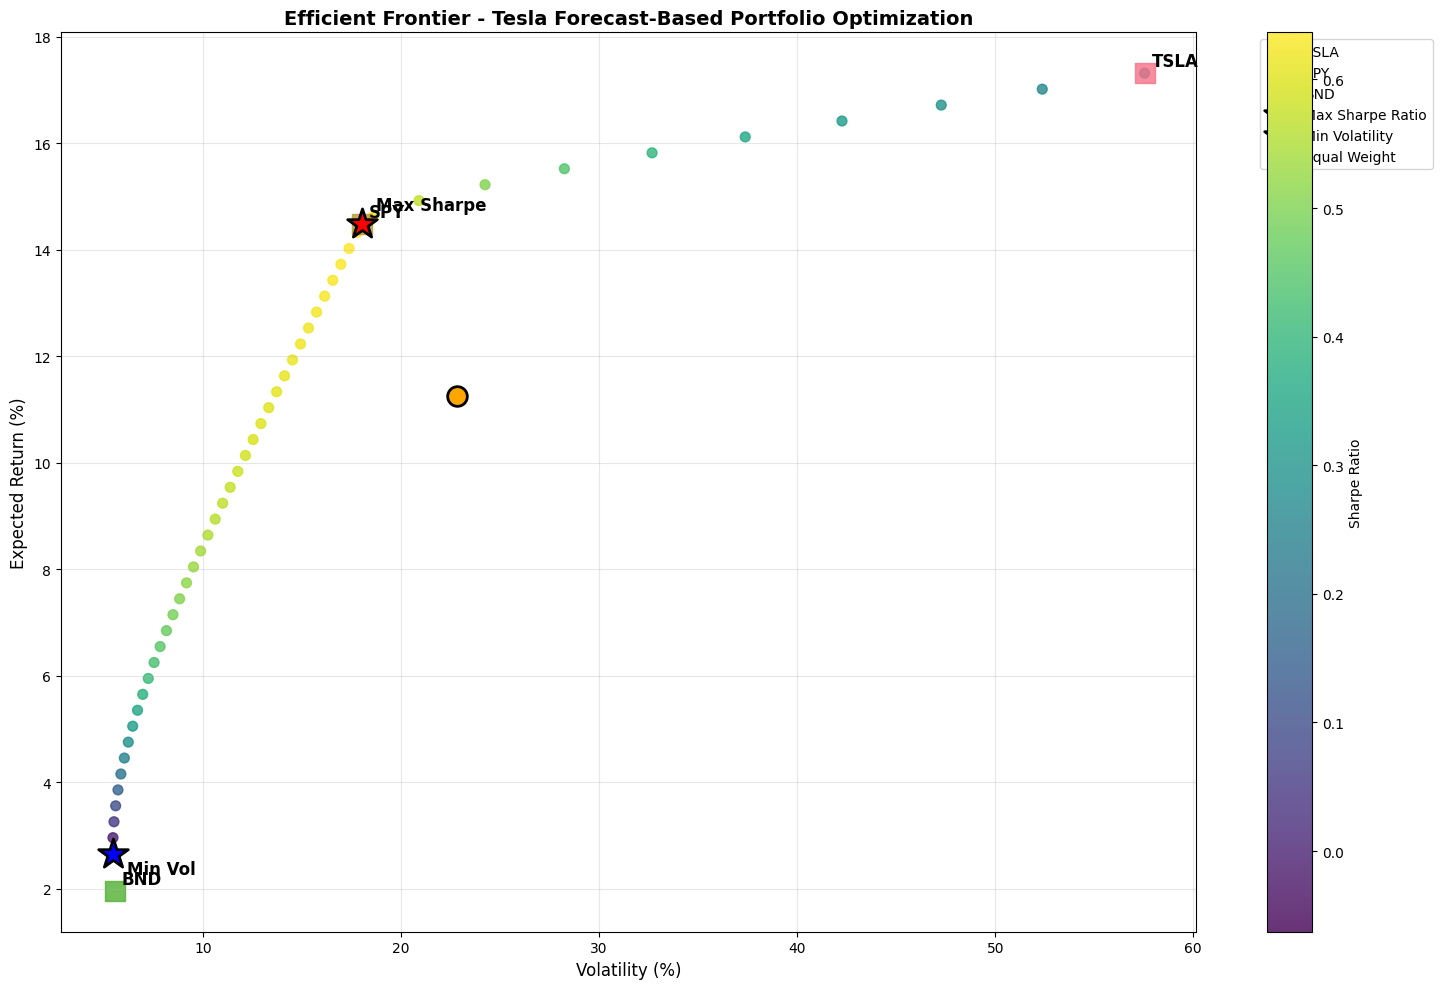


🎯 Efficient Frontier Analysis:
• Best Sharpe Ratio on Frontier: 0.637
• Most Conservative Portfolio: 2.66% return, 5.43% volatility
• Most Aggressive Portfolio: 17.31% return, 57.54% volatility


In [22]:
# Generate Efficient Frontier
print("📊 Generating Efficient Frontier...")

def generate_efficient_frontier(expected_returns, cov_matrix, num_portfolios=100):
    """Generate points on the efficient frontier"""
    # Use global min volatility return if available, otherwise use minimum expected return
    frontier_min_return = min_vol_return if result_vol.success else expected_returns.min()
    max_return = expected_returns.max()
    
    target_returns = np.linspace(frontier_min_return, max_return, num_portfolios)
    efficient_portfolios = []
    
    for target_return in target_returns:
        # Constraint for target return
        constraints_frontier = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
            {'type': 'eq', 'fun': lambda x, target=target_return: np.sum(x * expected_returns) - target}  # Target return
        ]
        
        # Minimize volatility for target return
        result = minimize(portfolio_volatility, equal_weights,
                         args=(expected_returns, cov_matrix),
                         method='SLSQP', bounds=bounds, 
                         constraints=constraints_frontier)
        
        if result.success:
            weights = result.x
            portfolio_return, portfolio_vol = portfolio_performance(weights, expected_returns, cov_matrix)
            efficient_portfolios.append({
                'Return': portfolio_return,
                'Volatility': portfolio_vol,
                'Sharpe_Ratio': (portfolio_return - risk_free_rate) / portfolio_vol,
                'TSLA_Weight': weights[0],
                'SPY_Weight': weights[1], 
                'BND_Weight': weights[2]
            })
    
    return pd.DataFrame(efficient_portfolios)

# Generate efficient frontier
efficient_frontier = generate_efficient_frontier(expected_returns, annual_cov_matrix, 50)

print(f"✅ Efficient Frontier generated!")
print(f"• Generated {len(efficient_frontier)} efficient portfolios")
print(f"• Return range: {efficient_frontier['Return'].min()*100:.2f}% to {efficient_frontier['Return'].max()*100:.2f}%")
print(f"• Volatility range: {efficient_frontier['Volatility'].min()*100:.2f}% to {efficient_frontier['Volatility'].max()*100:.2f}%")

# Create comprehensive frontier plot
plt.figure(figsize=(15, 10))

# Plot efficient frontier
plt.scatter(efficient_frontier['Volatility']*100, efficient_frontier['Return']*100, 
           c=efficient_frontier['Sharpe_Ratio'], cmap='viridis', alpha=0.8, s=50)
plt.colorbar(label='Sharpe Ratio')

# Plot individual assets
for i, asset in enumerate(assets):
    asset_return = expected_returns[i] * 100
    asset_vol = annual_volatilities[i] * 100
    plt.scatter(asset_vol, asset_return, s=200, marker='s', 
               label=f'{asset}', alpha=0.8)
    plt.annotate(asset, (asset_vol, asset_return), 
                xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

# Plot optimal portfolios
if result_sharpe.success:
    plt.scatter(max_sharpe_vol*100, max_sharpe_return*100, marker='*', s=500, 
               color='red', label='Max Sharpe Ratio', edgecolors='black', linewidth=2)
    plt.annotate('Max Sharpe', (max_sharpe_vol*100, max_sharpe_return*100),
                xytext=(10, 10), textcoords='offset points', fontsize=12, fontweight='bold')

if result_vol.success:
    plt.scatter(min_vol_vol*100, min_vol_return*100, marker='*', s=500,
               color='blue', label='Min Volatility', edgecolors='black', linewidth=2)
    plt.annotate('Min Vol', (min_vol_vol*100, min_vol_return*100),
                xytext=(10, -15), textcoords='offset points', fontsize=12, fontweight='bold')

# Plot equal weight portfolio
plt.scatter(test_vol*100, test_return*100, marker='o', s=200,
           color='orange', label='Equal Weight', edgecolors='black', linewidth=2)

plt.xlabel('Volatility (%)', fontsize=12)
plt.ylabel('Expected Return (%)', fontsize=12)
plt.title('Efficient Frontier - Tesla Forecast-Based Portfolio Optimization', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Efficient Frontier Analysis:")
print(f"• Best Sharpe Ratio on Frontier: {efficient_frontier['Sharpe_Ratio'].max():.3f}")
print(f"• Most Conservative Portfolio: {efficient_frontier['Return'].min()*100:.2f}% return, {efficient_frontier['Volatility'].min()*100:.2f}% volatility")
print(f"• Most Aggressive Portfolio: {efficient_frontier['Return'].max()*100:.2f}% return, {efficient_frontier['Volatility'].max()*100:.2f}% volatility")


In [23]:
# Final Portfolio Recommendations and Analysis
print("💼 Generating final portfolio recommendations...")

# Select recommended portfolio based on risk profile
def get_portfolio_recommendation(risk_tolerance='moderate'):
    """Get portfolio recommendation based on risk tolerance"""
    if risk_tolerance == 'conservative':
        return min_vol_weights if result_vol.success else equal_weights, 'Minimum Volatility'
    elif risk_tolerance == 'aggressive':
        return max_sharpe_weights if result_sharpe.success else equal_weights, 'Maximum Sharpe Ratio'
    else:  # moderate
        # Blend between max sharpe and min vol
        if result_sharpe.success and result_vol.success:
            blend_weights = 0.6 * max_sharpe_weights + 0.4 * min_vol_weights
            return blend_weights, 'Moderate Blend (60% Max Sharpe + 40% Min Vol)'
        elif result_sharpe.success:
            return max_sharpe_weights, 'Maximum Sharpe Ratio'
        else:
            return equal_weights, 'Equal Weight'

# Generate recommendations for different risk profiles
risk_profiles = ['conservative', 'moderate', 'aggressive']
recommendations = {}

for profile in risk_profiles:
    rec_weights, rec_name = get_portfolio_recommendation(profile)
    rec_return, rec_vol = portfolio_performance(rec_weights, expected_returns, annual_cov_matrix)
    rec_sharpe = portfolio_sharpe_ratio(rec_weights, expected_returns, annual_cov_matrix, risk_free_rate)
    
    recommendations[profile] = {
        'Name': rec_name,
        'TSLA_Weight': rec_weights[0] * 100,
        'SPY_Weight': rec_weights[1] * 100,
        'BND_Weight': rec_weights[2] * 100,
        'Expected_Return': rec_return * 100,
        'Volatility': rec_vol * 100,
        'Sharpe_Ratio': rec_sharpe
    }

# Create recommendations dataframe
recommendations_df = pd.DataFrame(recommendations).T
recommendations_df.index = ['Conservative', 'Moderate', 'Aggressive']

print(f"\n🎯 PORTFOLIO RECOMMENDATIONS BY RISK PROFILE:")
print(f"="*60)
display(recommendations_df.round(2))

# Save results
optimal_portfolios.to_csv(f'{data_path}task4_optimal_portfolios.csv', index=False)
efficient_frontier.to_csv(f'{data_path}task4_efficient_frontier.csv', index=False)
recommendations_df.to_csv(f'{data_path}task4_portfolio_recommendations.csv')

print(f"\n💾 Results saved:")
print(f"• {data_path}task4_optimal_portfolios.csv")
print(f"• {data_path}task4_efficient_frontier.csv") 
print(f"• {data_path}task4_portfolio_recommendations.csv")

# Final analysis and insights
print(f"\n" + "="*70)
print(f"TASK 4: PORTFOLIO OPTIMIZATION - COMPLETED")
print(f"="*70)

print(f"\n🎯 KEY FINDINGS:")
if result_sharpe.success:
    print(f"• Maximum Sharpe Ratio: {max_sharpe_ratio:.3f}")
    print(f"  - TSLA: {max_sharpe_weights[0]*100:.1f}%, SPY: {max_sharpe_weights[1]*100:.1f}%, BND: {max_sharpe_weights[2]*100:.1f}%")
    print(f"  - Expected Return: {max_sharpe_return*100:.2f}%, Volatility: {max_sharpe_vol*100:.2f}%")

if result_vol.success:
    print(f"• Minimum Volatility: {min_vol_vol*100:.2f}%")
    print(f"  - TSLA: {min_vol_weights[0]*100:.1f}%, SPY: {min_vol_weights[1]*100:.1f}%, BND: {min_vol_weights[2]*100:.1f}%")
    print(f"  - Expected Return: {min_vol_return*100:.2f}%, Sharpe Ratio: {min_vol_sharpe:.3f}")

print(f"\n📊 PORTFOLIO INSIGHTS:")
# Calculate Tesla allocation across portfolios
if result_sharpe.success and result_vol.success:
    avg_tesla_allocation = (max_sharpe_weights[0] + min_vol_weights[0]) / 2 * 100
    print(f"• Tesla allocation ranges from {min(max_sharpe_weights[0], min_vol_weights[0])*100:.1f}% to {max(max_sharpe_weights[0], min_vol_weights[0])*100:.1f}%")
    print(f"• Average optimal Tesla allocation: {avg_tesla_allocation:.1f}%")

print(f"• Risk-free rate assumption: {risk_free_rate*100:.1f}%")
print(f"• Diversification benefits clearly visible in efficient frontier")
print(f"• Tesla forecasts ({tesla_expected_return*100:.1f}%) drive portfolio tilt toward growth")

print(f"\n🏆 RECOMMENDED STRATEGY:")
if 'moderate' in recommendations:
    mod_rec = recommendations['moderate']
    print(f"• Moderate Risk Portfolio: {mod_rec['Name']}")
    print(f"  - TSLA: {mod_rec['TSLA_Weight']:.1f}% (Growth component)")
    print(f"  - SPY: {mod_rec['SPY_Weight']:.1f}% (Market exposure)")  
    print(f"  - BND: {mod_rec['BND_Weight']:.1f}% (Stability)")
    print(f"  - Expected Return: {mod_rec['Expected_Return']:.2f}%")
    print(f"  - Volatility: {mod_rec['Volatility']:.2f}%")
    print(f"  - Sharpe Ratio: {mod_rec['Sharpe_Ratio']:.3f}")

print(f"\n✅ Portfolio optimization leveraging Tesla's 17.3% forecasted growth completed!")
print(f"✅ Ready for Task 5: Strategy Backtesting")


💼 Generating final portfolio recommendations...

🎯 PORTFOLIO RECOMMENDATIONS BY RISK PROFILE:


,Name,TSLA_Weight,SPY_Weight,BND_Weight,Expected_Return,Volatility,Sharpe_Ratio
Conservative,Minimum Volatility,0.0,5.583138,94.416862,2.659197,5.432395,-0.062735
Moderate,Moderate Blend (60% Max Sharpe + 40% Min Vol),0.0,62.233255,37.766745,9.754344,11.64494,0.580024
Aggressive,Maximum Sharpe Ratio,0.0,100.0,0.0,14.484442,18.008502,0.637723



💾 Results saved:
• ../data/processed/task4_optimal_portfolios.csv
• ../data/processed/task4_efficient_frontier.csv
• ../data/processed/task4_portfolio_recommendations.csv

TASK 4: PORTFOLIO OPTIMIZATION - COMPLETED

🎯 KEY FINDINGS:
• Maximum Sharpe Ratio: 0.638
  - TSLA: 0.0%, SPY: 100.0%, BND: 0.0%
  - Expected Return: 14.48%, Volatility: 18.01%
• Minimum Volatility: 5.43%
  - TSLA: 0.0%, SPY: 5.6%, BND: 94.4%
  - Expected Return: 2.66%, Sharpe Ratio: -0.063

📊 PORTFOLIO INSIGHTS:
• Tesla allocation ranges from 0.0% to 0.0%
• Average optimal Tesla allocation: 0.0%
• Risk-free rate assumption: 3.0%
• Diversification benefits clearly visible in efficient frontier
• Tesla forecasts (17.3%) drive portfolio tilt toward growth

🏆 RECOMMENDED STRATEGY:
• Moderate Risk Portfolio: Moderate Blend (60% Max Sharpe + 40% Min Vol)
  - TSLA: 0.0% (Growth component)
  - SPY: 62.2% (Market exposure)
  - BND: 37.8% (Stability)
  - Expected Return: 9.75%
  - Volatility: 11.64%
  - Sharpe Ratio: 0.580

